In [3]:
from __future__ import absolute_import, division, print_function

import collections
import functools
import os
import six
import time
import glob
from datetime import datetime
import pickle

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import datetime

# Process Results

In [4]:
experiment = 'avoidance_K15'

## Load DFL files

In [5]:
path = 'results/' + experiment + '/DFL_history*'

results_DFL = {}
exp_DFL = []

for filename in glob.iglob(path): 
    print(filename)
    
    temp = filename.split('_')
    exp_id = temp[4] + temp[5]
    print(exp_id)
#     exp_id = filename[-6:]
    exp_DFL.append(exp_id)
    
    results_DFL.update({exp_id : {'history' : [] , 'summary' : []}})
    
    filehandler = open(filename, 'rb') 
    results_DFL[exp_id]['history'] = pickle.load(filehandler)
    filehandler.close()
    
    filename = filename.replace("history", "summary")
    if os.path.isfile(filename):
        filehandler = open(filename, 'rb')
        results_DFL[exp_id]['summary'] = pickle.load(filehandler)  
        filehandler.close()


results/avoidance_K15/DFL_history_000708_06_60_20200315-143349
0660
results/avoidance_K15/DFL_history_000708_02_60_20200315-144325
0260
results/avoidance_K15/DFL_history_000708_02_20_20200315-153732
0220
results/avoidance_K15/DFL_history_000708_06_20_20200315-151406
0620


## Load FL files

In [6]:
path = 'results/' + experiment +'/FL_history*'

results_FL = {}
exp_FL = []

for filename in glob.iglob(path): 
    print(filename)
    
#     exp_id = filename[-6:]
    temp = filename.split('_')
    exp_id = temp[4] + temp[5]
    exp_FL.append(exp_id)
    
    results_FL.update({exp_id : {'history' : [] , 'summary' : []}})
    
    filehandler = open(filename, 'rb') 
    results_FL[exp_id]['history'] = pickle.load(filehandler)
    filehandler.close()
    
    filename = filename.replace("history", "summary")
    if os.path.isfile(filename):
        filehandler = open(filename, 'rb')
        results_FL[exp_id]['summary'] = pickle.load(filehandler)  
        filehandler.close()

results/avoidance_K15/FL_history_000708_02_20_20200315-153331
results/avoidance_K15/FL_history_000708_02_60_20200315-144742
results/avoidance_K15/FL_history_000708_06_20_20200315-153312
results/avoidance_K15/FL_history_000708_06_60_20200315-144148


## Load Centralized files

In [7]:
path = 'results/' + experiment +'/Centralized*'

results_C = {}
exp_C = []

for filename in glob.iglob(path): 
    
    print(filename)
#     exp_id = filename[-6:]
    temp = filename.split('_')
    exp_id = temp[3] + temp[4]
    exp_C.append(exp_id)
    
    results_C.update({exp_id : []})
    
    filehandler = open(filename, 'rb') 
    results_C[exp_id] = pickle.load(filehandler)
    filehandler.close()

results/avoidance_K15/Centralized_000708_06_20_20200315-152857
results/avoidance_K15/Centralized_000708_02_20_20200315-163343
results/avoidance_K15/Centralized_000708_06_60_20200315-143930
results/avoidance_K15/Centralized_000708_02_60_20200315-150247


In [8]:
exp_C.sort()
exp_DFL.sort()
exp_FL.sort()

In [9]:
print(exp_DFL)
print(exp_C)
print(exp_FL)

['0220', '0260', '0620', '0660']
['0220', '0260', '0620', '0660']
['0220', '0260', '0620', '0660']


## Validation Loss

In [56]:
def get_average_loss(history):
    for exp in history.keys():
        avg_val_loss = np.zeros(len(history[exp]))
        for round_num in range(1, len(history[exp])+1):
            count = 0.
            sum_loss = 0.
            for robot in history[exp].keys():
                if (robot in history[exp][round_num].keys()):
                    num_samples = history[exp][round_num][robot]['num_samples']
                    count += num_samples
                    sum_loss += num_samples * history[exp][round_num][robot]['losses']['val_loss'][0]
            if(count != 0):
                avg_val_loss[round_num - 1] = sum_loss/count
    return avg_val_loss

In [57]:
def get_time_of_round(round_num, summary):
    for exp in summary.keys():
        return summary[exp]['entry_barrier_end'][round_num-1]

In [58]:
def get_time_of_round_FL(round_num, summary):
    for exp in summary.keys():
        return summary[exp]['round_time'][round_num-1]

In [59]:
def get_round_of_convergence(loss, threshold_p=0.1):
    thresh = threshold_p * min(loss) #loss[-1]
    finite_diff = abs(loss - min(loss)) #loss[-1]
    return list(map(lambda i: i< thresh, finite_diff)).index(True)+1 

0220
0260
0620
0660


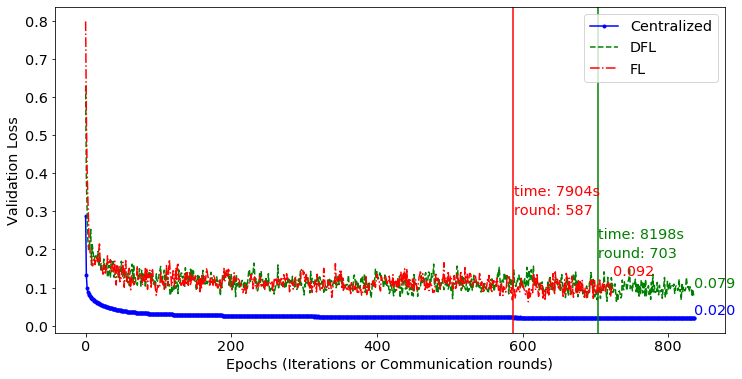

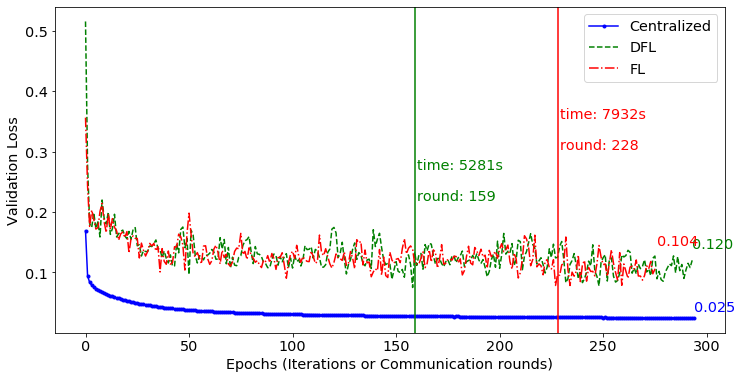

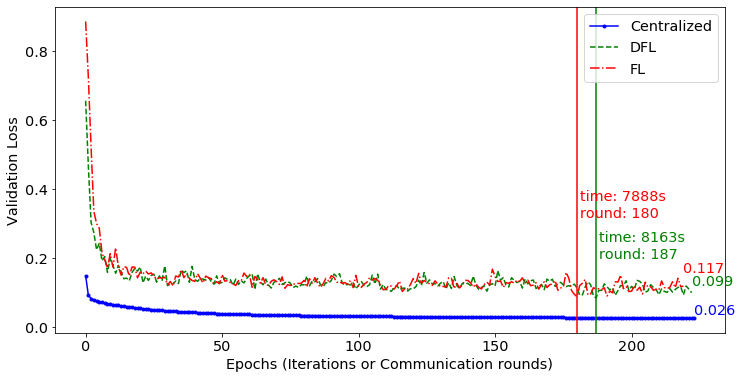

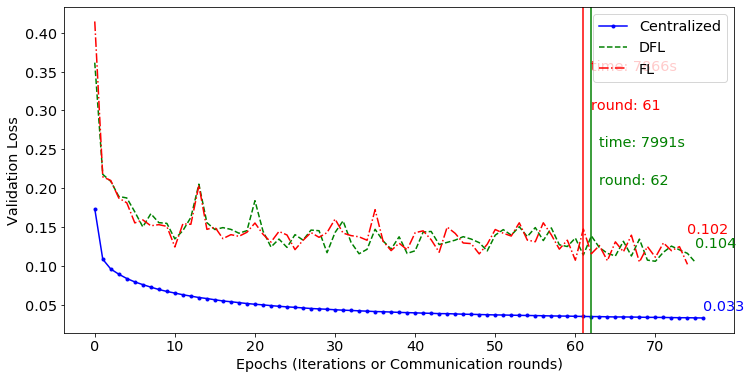

In [61]:
for exp_c, exp_d, exp_f in zip(exp_C, exp_DFL, exp_FL):
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    # Centralized
    loss_C = results_C[exp_c]['losses']['val_loss']
    plt.plot(loss_C, 'b.-', label='Centralized')
    ax.annotate(format(loss_C[-1], '.3f') , xy= (len(loss_C)-1, loss_C[-1] + 0.01), color='b',fontsize='x-large')
    
    # DFL
    loss_DFL = get_average_loss(results_DFL[exp_d]['history'])
    plt.plot(loss_DFL, 'g--', label='DFL')
    ax.annotate(format(loss_DFL[-1], '.3f') , xy= (len(loss_DFL)-1, loss_DFL[-1] + 0.02), color='g', fontsize='x-large')
    if len(results_DFL[exp_d]['summary']) != 0:
        conv_round = get_round_of_convergence(loss_DFL)
        t_conv = get_time_of_round(conv_round, results_DFL[exp_d]['summary'])
        plt.axvline(x=conv_round, color='g')
        ax.annotate("time: " + format(t_conv/10, '.0f') + "s", xy= (conv_round + 1, loss_DFL[-1] + 0.15), color='g', fontsize='x-large')
        ax.annotate("round: " + format(conv_round, '.0f') , xy= (conv_round + 1, loss_DFL[-1] + 0.1), color='g', fontsize='x-large')
        
    # FL
    loss_FL = get_average_loss(results_FL[exp_f]['history'])
    plt.plot(loss_FL, 'r-.', label='FL')
    ax.annotate(format(loss_FL[-1], '.3f') , xy= (len(loss_FL)-1, loss_FL[-1] + 0.04), color='r', fontsize='x-large')
    if len(results_FL[exp_f]['summary']) != 0:
        conv_round = get_round_of_convergence(loss_FL)
        plt.axvline(x=conv_round, color='r')
        t_conv = get_time_of_round_FL(conv_round, results_FL[exp_f]['summary'])
        ax.annotate("time: " + format(t_conv/10, '.0f') + "s", xy= (conv_round + 1, loss_FL[-1] + 0.25), color='r', fontsize='x-large')
        ax.annotate("round: " + format(conv_round, '.0f') , xy= (conv_round + 1, loss_FL[-1] + 0.2), color = 'r',fontsize='x-large')
        
    print(exp_c)
#     plt.plot(avg_val_loss[avg_val_loss!=0], 'r*-', label='FA')
    plt.legend(loc='upper right', fontsize='x-large')
    ax.tick_params(labelsize='x-large')
    plt.xlabel('Epochs (Iterations or Communication rounds)', fontsize='x-large')
    plt.ylabel('Validation Loss', fontsize='x-large')

## Inter-epoch time

In [62]:
def get_timing(history, summary):
    for exp in history.keys():
        timings = np.zeros((len(history[exp]), 4))
        # timings[r] = [entry_b_start, entry_b_end, training_min_duration, exit_b_end]
        for round_num in range(1, len(history[exp])+1):
            #print(summary[exp])
            ebs = 0#summary[exp]['entry_barrier_start'][round_num-1]
            ebe = summary[exp]['entry_barrier_end'][round_num-1]
            exbe = summary[exp]['exit_barrier_end'][round_num-1]
            durations = []
            for robot in history[exp].keys():
                if (robot in history[exp][round_num].keys()):
                    durations.append(history[exp][round_num][robot]['time'])
            exbs = min(durations) + ebe
            timings[round_num-1] = [ebs, ebe, exbs, exbs]
    return timings

0220
0260
0620
0660


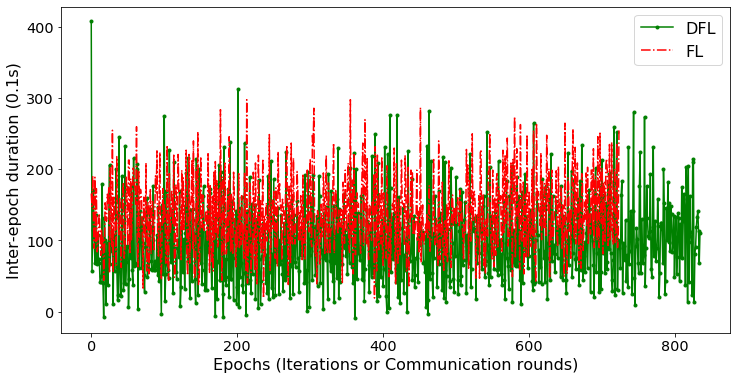

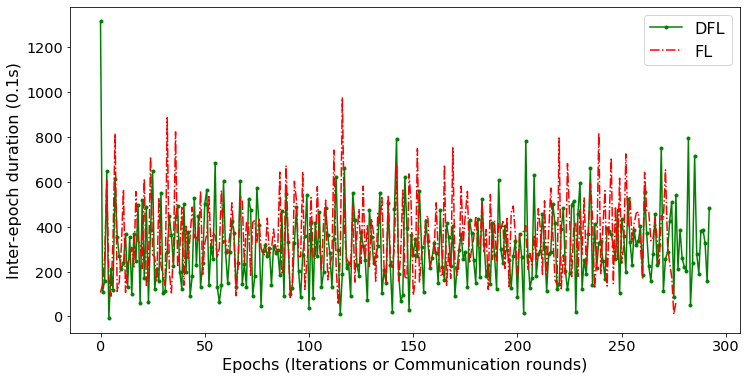

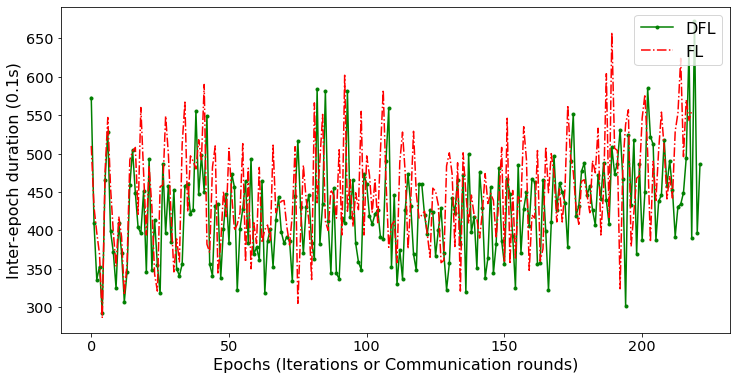

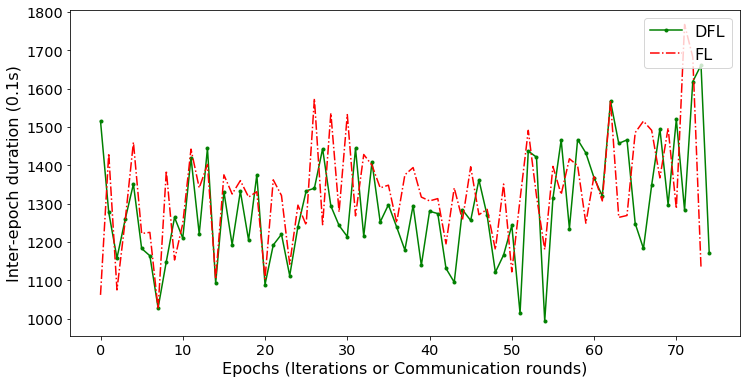

In [63]:
for exp_d, exp_f in zip(exp_DFL, exp_FL):
    if len(results_DFL[exp_d]['summary']) != 0:
        fig = plt.figure(figsize=(12, 6))
        ax = plt.gca()
        timings_DFL = get_timing(results_DFL[exp_d]['history'], results_DFL[exp_d]['summary'])
        inter_epoch = np.zeros(len(timings_DFL)-1)
        inter_epoch[0] = timings_DFL[0][1]
        for i in range(1, len(timings_DFL)-1):
            inter_epoch[i] = timings_DFL[i+1][1] - timings_DFL[i][2]
        plt.plot(inter_epoch, 'g.-', label='DFL')
        print(exp_d)
    #     plt.plot(avg_val_loss[avg_val_loss!=0], 'r*-', label='FA')

    if  len(results_FL[exp_f]['summary']) != 0:
        for elem in results_FL[exp_f]['summary'].values():
            inter_epoch = np.diff(list(elem['round_time'].values()))
            plt.plot(inter_epoch[inter_epoch>0], 'r-.', label='FL')
    plt.legend(loc='upper right', fontsize=16)
    ax.tick_params(labelsize='x-large')
    plt.xlabel('Epochs (Iterations or Communication rounds)', FontSize=16)
    plt.ylabel('Inter-epoch duration (0.1s)', FontSize=16)

## Number of participants

In [64]:
def get_participants(summary):
    for exp in summary.keys():
        num_particip = np.zeros(len(summary[exp]['num_participants']))
        for round_num in range(len(summary[exp]['num_participants'])):
            num_particip[round_num] = summary[exp]['num_participants'][round_num+1]
        return num_particip

0220
0260
0620
0660


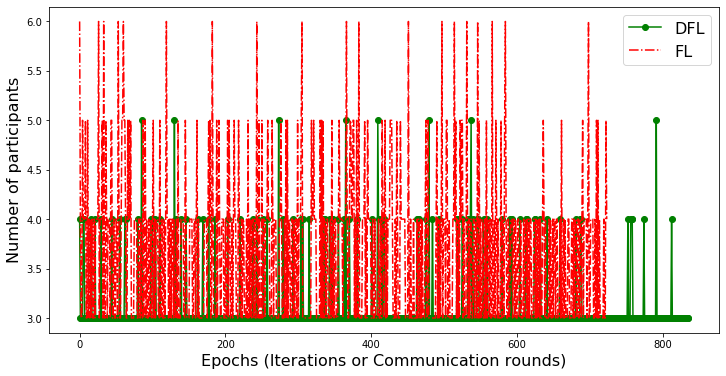

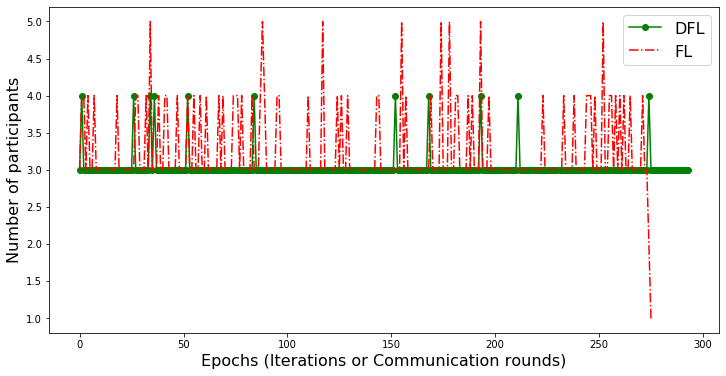

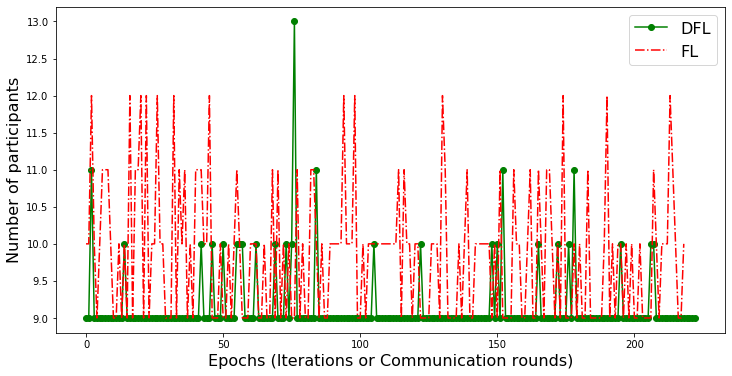

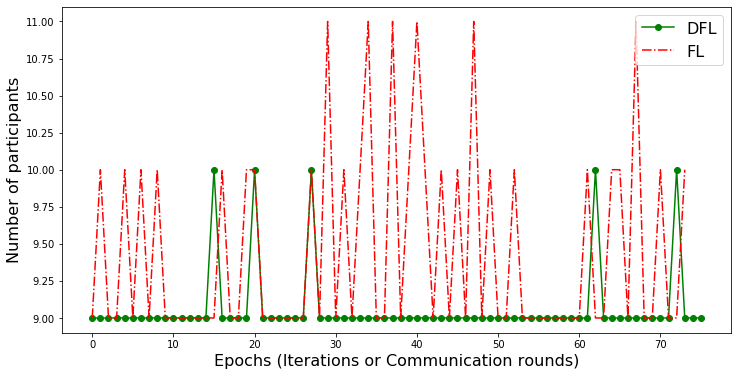

In [65]:
for exp_d, exp_f in zip(exp_DFL, exp_FL):
    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    if not isinstance(results_DFL[exp_d]['summary'], list):
        num_p = get_participants(results_DFL[exp_d]['summary'])
        plt.plot(num_p, 'go-', label='DFL')
        
    num_p_FL = get_participants(results_FL[exp_f]['summary'])

    plt.plot(num_p_FL[:-1], 'r-.', label='FL')
    print(exp_d)

    plt.legend(loc='upper right', fontsize=16)
    plt.xlabel('Epochs (Iterations or Communication rounds)', FontSize=16)
    plt.ylabel('Number of participants', FontSize=16)

# Prediction Quality

## Load Final Models

In [10]:
centralized_models_list = []
FL_models_list = []
DFL_models_list = []
for exp_c, exp_d, exp_f in zip(exp_C, exp_DFL, exp_FL):
    centralized_models_list.append(results_C[exp_c]['last_weights'])
    if not isinstance(results_DFL[exp_d]['summary'], list):
        for exp in results_DFL[exp_d]['summary'].values():
            DFL_models_list.append(exp['last_weights'])
    else:
        print("DFL missing", exp_d)
    if not isinstance(results_FL[exp_f]['summary'], list):
        for exp in results_FL[exp_f]['summary'].values():
            FL_models_list.append(exp['last_weights'])
    else:
        print("FL missing", exp_f)

## Load Test Datasets

In [11]:
path = '../data/data/15/avoidance*'

samples = {} # samples{ <exp_id> : {<rid>: { <traj_id> : { 'traj' : [], 'end' : <time_collected> }}}
# Iterate over experiments
for filename in glob.iglob(path): 
    print(filename)
    exp_id = filename[-10:-4]
    last_sample_keys = {}
    samples.update({exp_id : {}})
    # Read in experiment file
    for line in open(filename):
            data = line.split(',')
            # Trajectory data?
            if len(data) == 7:
                rid = int(data[0])
                t = int(data[2])
                # Skip data used for training and validaton
                if t < 99000:
                    continue
                # Get trajectory point
                x1 = float(data[3])
                x2 = float(data[4])
                # Already created a key for this robot?
                if rid in samples[exp_id].keys():
                    last_key = last_sample_keys[rid]
                    # Previous sample id dismissed (not created after new line)
                    if(last_key not in samples[exp_id][rid]):
                        samples[exp_id][rid][last_key] = {'traj': [], 'end' : 0}
                    # Add trajectory point
                    samples[exp_id][rid][last_key]['traj'].append((x1, x2))
                    # Update end time temporarily
                    samples[exp_id][rid][last_key]['end'] = t
                    # Full length trajectory?
                    if len(samples[exp_id][rid][last_key]['traj']) == 99:
                        # Remove last point to have even number 
                        del samples[exp_id][rid][last_key]['traj'][98]
                        # Set final end time
                        samples[exp_id][rid][last_key]['end'] = t - 1
                        # Increment last sample id
                        last_sample_keys[rid]+=1
                else:
                    # Create new entry for robot
                    samples[exp_id].update({rid: {}})
                    # Add first trajectory point
                    samples[exp_id][rid].update({0: {'traj': [(x1, x2)], 'end': 0}})
                    # Set last sample id to 0 (first sample)
                    last_sample_keys.update({rid: 0})
            # End of line and previous time step > 99000?
            elif t > 99000:
                last_key = last_sample_keys[rid]
                # If we had recorded the trajectory
                if(last_key in samples[exp_id][rid]):
                    # Full trajectory?
                    if len(samples[exp_id][rid][last_key]['traj']) == 98:
                        # Increment sample id
                        last_sample_keys[rid]+=1
                    else:
                        # Delete incomplete trajectory
                        if(last_key != 0):
                            del samples[exp_id][rid][last_key]
                            last_sample_keys[rid] = last_sample_keys[rid] - 1
                        else: 
                            del samples[exp_id][rid]
                            del last_sample_keys[rid]

#     temp = filename.split('_')
#     exp_id = temp[4] + temp[5]
#     print(exp_id)
# #     exp_id = filename[-6:]
#     exp_DFL.append(exp_id)
    

../data/data/15/avoidance_20200221_000708.dat


In [12]:
print(len(samples['000708'][1].values()))

41


In [19]:

for k,v in samples['000708'].items():
    copy = {}
    for kk, vv in v.items():
        if len(vv['traj']) != 98:
            print(k, len(v),len(vv['traj']))
            # print(samples['000708'][k][kk])
        else:
            copy.update({kk : vv})
    samples['000708'][k] = copy
            # del samples['000708'][k][kk]

In [22]:
print(exp_id)

000708


## Prediction Errors

In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [67]:
EMBEDDING_SIZE = 32
NUM_OUTPUTS = 2
sample_shape = (49,2)
def create_model():
    return tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=-10.,input_shape=sample_shape),
    tf.keras.layers.LSTM(EMBEDDING_SIZE,
                         return_sequences=True,
                         input_shape=sample_shape),
    tf.keras.layers.Dense(NUM_OUTPUTS)
    ])

In [71]:
for exp_c in exp_C:
    ADE = 0.
    FDE = 0.
    count = 0
    for weights in centralized_models_list:
        for rid in range(1,len(samples[exp_id].values())):
            for trajectory in samples[exp_id][rid].values():
                ground_truth = trajectory['traj']
                t_end = trajectory['end']
                t_ini = t_end - 98
                final_lstm = create_model()#tf.keras.models.load_model('lstm.h5', compile=False)
                keras_model_clone = tf.keras.models.clone_model(final_lstm)
                keras_model_clone.compile(optimizer='SGD', loss='mean_absolute_error')
                keras_model_clone.set_weights(weights)
                # print("ground truth", ground_truth)
                # print(np.array(ground_truth[0:49]))
                # x = ground_truth.
                x = np.array(ground_truth[0:49])
                y = np.expand_dims(x, axis=0)
                prediction = final_lstm.predict(y)[0]
                # print("prediction", len(prediction))
                FDE += compute_FDE(ground_truth[49:], prediction)
                print(FDE)
                ADE += compute_ADE(np.array(ground_truth[49:]), prediction)
                print(ADE)
                count += 1.
                # break
            # break
        # break
    # break
    ADE /= count
    FDE /= count
    print("ADE", exp_c, ADE)
    print("FDE", exp_c,FDE)

2.5891513155402426
2.5120174964614064


In [60]:
print(ground_truth[-1][0])
print(np.array(ground_truth[49:])[:,0])
print(prediction)
print(prediction[:,0])#reshape(-1,2))

1.36669
[1.32999 1.23235 1.34875 1.23167 1.34981 1.31781 1.34652 1.3136  1.30927
 1.30863 1.33904 1.29762 1.31052 1.1752  1.29085 1.42172 1.34732 1.31049
 1.44559 1.28838 1.25726 1.34875 1.30712 1.3109  1.38899 1.32885 1.41033
 1.31346 1.41656 1.30882 1.29988 1.31411 1.30713 1.30922 1.31568 1.306
 1.38239 1.30448 1.35094 1.312   1.26055 1.31114 1.31273 1.30743 1.30848
 1.31042 1.348   1.44431 1.36669]
[[-0.02970468  0.06743687]
 [-0.04892733  0.11705878]
 [-0.06232025  0.14985459]
 [-0.0746628   0.17625074]
 [-0.08352553  0.19259243]
 [-0.08977291  0.20363949]
 [-0.09396096  0.21119227]
 [-0.09919417  0.21428439]
 [-0.10200559  0.22021356]
 [-0.1077062   0.22080207]
 [-0.11042461  0.22108464]
 [-0.1122053   0.22268236]
 [-0.11016095  0.22543374]
 [-0.11308499  0.2267529 ]
 [-0.12253074  0.22330123]
 [-0.12294313  0.22103965]
 [-0.12353773  0.22220276]
 [-0.12314245  0.22497101]
 [-0.12462195  0.22447103]
 [-0.12934703  0.21919706]
 [-0.13095182  0.22063005]
 [-0.13246442  0.22015916]
 

## Metrics

In [39]:
import math

### Final Displacement Error

In [40]:
def compute_FDE(ground_truth, prediction):
    return math.sqrt(((ground_truth[-1][0] - prediction[-1][0]) ** 2) + ((ground_truth[-1][1] - prediction[-1][1]) ** 2))

### Average Displacement Error

In [70]:
def compute_ADE(ground_truth, prediction):
    return np.average(np.sqrt(np.square(ground_truth[:,0] - prediction[:,0])  + np.square(ground_truth[:,1] - prediction[:,1])))